In [95]:
import numpy as np
s = open('dat2').read().strip()
len(s.strip().split())

37562

In [96]:
gate10_pert = np.float32([1.469281,1.627975,0])
#gate10_pert = np.float32([1.469281,1.627975,-1.086318])

w = 1028
h = 768
fov = 70.0

def q_rot(q, r):
    qr = np.quaternion(0.0, r[0], r[1], r[2])
    qr = q * qr * q.conjugate()
    return np.array([qr.x, qr.y, qr.z])

def camera_ray(x, y, q):
    x = (x - w/2)/(w/2)
    y = (y - h/2)/(h/2)
    x = x*(fov/2/45.0)
    y = y*(fov/2/45.0)
    v = np.float32([1, -x, -y])
    return q_rot(q, v / np.linalg.norm(v))

def ray_p_dist(o, d, p, pert=np.float32([0.0, 0.0, 0.0])):
    pdot = p - o
    pdot -= gate10_pert
    return np.linalg.norm(np.cross(pdot, d))

In [97]:
gate_pos = {}
gate_pos['Gate10'] = {3: [19.6202, 5.276512, 5.383497], 1: [19.6202, 5.276512, 7.229498], 4: [17.82052, 5.242493, 5.383497], 2: [17.82052, 5.242493, 7.229498]}

In [98]:
pos = []
import numpy as np
import quaternion
q = []
marker = []
from collections import defaultdict
i = 0
lines = s.strip().split('\n')
markers = defaultdict(dict)
l = ' '
while i < len(lines):
    l = lines[i].strip()
    if l == 'new':
        marker.append(markers)
        markers = defaultdict(dict)
        i += 1
        if i == len(lines):
            break
        l = lines[i]
        pos.append(np.float32([float(x) for x in l.strip().split()]))
        i += 1
        l = lines[i]
        q.append(np.quaternion(*[float(x) for x in l.strip().split()]))
        i += 1
    else:
        x = l.strip().replace('"', '').split('data: ')[1:]
        v = x[1].strip().split()
        ray = camera_ray(float(v[1]),float(v[2]), q[-1])
        ir_pos = np.float32(v[1:])
        x[0] = x[0].strip()
        if x[0] == 'Gate10':
            markers[x[0]][int(v[0])] = {'pos': ir_pos, 
                                        'ray': ray,
                                        'dist': ray_p_dist(pos[-1], ray, gate_pos[x[0]][int(v[0])], np.float32([1.469281,1.627975,-1.086318]))
                                       }
        i += 1
marker.pop(0)

defaultdict(dict, {})

In [99]:
gate_mean = {}
for g in gate_pos:
    acc = np.float32([0, 0, 0])
    for i in range(1,5):
        acc += gate_pos[g][i]
    acc /= 4
    gate_mean[g] = acc

In [100]:
pos[0]

array([ 18. , -23. ,   5.3], dtype=float32)

In [101]:
gate_mean['Gate10']

array([18.72036  ,  5.2595024,  6.3064976], dtype=float32)

In [102]:
gate_pos

{'Gate10': {3: [19.6202, 5.276512, 5.383497],
  1: [19.6202, 5.276512, 7.229498],
  4: [17.82052, 5.242493, 5.383497],
  2: [17.82052, 5.242493, 7.229498]}}

In [103]:
for i in range(1, 5):
    dist = np.linalg.norm((gate_pos['Gate10'][i] - gate10_pert - pos[0]))
    res = marker[0]['Gate10'][i]['ray'] * dist + pos[0]
    print(res)
    print(gate_pos['Gate10'][i] - gate10_pert)
    print(np.linalg.norm(res - gate_pos['Gate10'][i] + gate10_pert))

[18.0045609   3.63597465  7.29599878]
[18.15091904  3.64853701  7.229498  ]
0.16124785964784027
[16.57872396  3.61474086  7.29443714]
[16.35123904  3.61451801  7.229498  ]
0.2365724614358785
[18.00456423  3.64102173  5.33716878]
[18.15091904  3.64853701  5.383497  ]
0.15369617843011146
[16.5784611   3.61966402  5.33713898]
[16.35123904  3.61451801  5.383497  ]
0.23195993139284135


In [104]:
def axis_angle(axis, angle):
    x = axis[0] * np.sin(angle)
    y = axis[1] * np.sin(angle)
    z = axis[2] * np.sin(angle)
    return np.quaternion(np.cos(angle), x, y, z)

def camera_test():
    for i in range(1000):
        o = np.float32([0.0, 0.0, 0.0])
        p = np.float32([5.0, 0.0, 0.0])
        v = np.random.rand(3)
        v = v/np.linalg.norm(v)
        angle = np.random.rand(1) * 0.1
        q = axis_angle(v, angle)
        pdot = q_rot(q.conjugate(), p)
        pdot /= pdot[0]
        print(pdot)
        ray = camera_ray(w/2 + p[1], h/2 + p[2], q)
        dist = np.linalg.norm(p)
        print('error', ray_p_dist(o, p, ray))

In [105]:
marker

[defaultdict(dict,
             {'Gate10': {1: {'pos': array([514.11316, 347.00293], dtype=float32),
                'ray': array([1.70700606e-04, 9.96902910e-01, 7.47041110e-02]),
                'dist': 0.16102082677609436},
               2: {'pos': array([478.709  , 347.00238], dtype=float32),
                'ray': array([-0.05316111,  0.99549226,  0.07459951]),
                'dist': 0.23639658840800326},
               3: {'pos': array([514.1132, 383.3112], dtype=float32),
                'ray': array([1.71271378e-04, 9.99697047e-01, 1.39474109e-03]),
                'dist': 0.15346155939409767},
               4: {'pos': array([478.709 , 383.3112], dtype=float32),
                'ray': array([-0.0533097 ,  0.99827471,  0.00139276]),
                'dist': 0.2317829932805361}}}),
 defaultdict(dict,
             {'Gate10': {1: {'pos': array([514.11316, 347.00293], dtype=float32),
                'ray': array([1.70700606e-04, 9.96902910e-01, 7.47041110e-02]),
                'd

In [168]:
def screen_space(x, y):
    x = (x - w/2)/(w/2)
    y = (y - h/2)/(h/2)
    return x, y

def camera_proj(q, p):
    pdot = q_rot(q.conjugate(), p)
    x = pdot[1] / pdot[0]
    y = pdot[2] / pdot[0]
    return np.float32([-x, -y])

x_fit = []
xdot_fit = []
#array([ 0.13226633, -0.02474519], dtype=float32), array([ 0.02093541, -0.03245282]
trans_corr = np.float32([0.13226633 - 0.02093541, -0.02474519 + 0.03245282])
for i in range(len(marker))[300:500]:
    pic = marker[i]['Gate10'][1]['pos']
    x, y = screen_space(pic[0], pic[1])
    xdot_fit.append(np.float32([x, y]))
    x_fit.append(camera_proj(q[i], gate_pos['Gate10'][1] + gate10_pert - pos[i]))


In [169]:
# Solve distortion model, start with radial only
A = np.zeros((len(x_fit)*2, 2))
b = np.zeros((len(x_fit)*2, 1))
for i in range(int(A.shape[0]/2)):
    ri2 = np.linalg.norm(x_fit[i])**2
    A[i*2, 0] = ri2
    A[i*2, 1] = ri2**2
    A[i*2+1, 0] = ri2
    A[i*2+1, 1] = ri2**2
    b[i*2, 0] = xdot_fit[i][0]/x_fit[i][0] - 1
    b[i*2+1, 0] = xdot_fit[i][1]/x_fit[i][1] - 1

k, residuals, rank, sing = np.linalg.lstsq(A, b)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  del sys.path[0]


In [170]:
k

array([[  490.29153065],
       [-6901.84515403]])

In [171]:
def radial_correction(x):
    k = [47.8668192, -365.26588906]
    r2 = np.linalg.norm(x)**2
    return (1 + k[0] * r2 + k[1] + r2 ** 2) * x

In [172]:
for i in range(len(marker)):
    pic = marker[i]['Gate10'][1]['pos']
    x, y = screen_space(pic[0], pic[1])
    xdot = np.float32([x, y])
    x = camera_proj(q[i], gate_pos['Gate10'][1] + gate10_pert - pos[i])
    print('error: ', xdot - radial_correction(x))

error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.55973  -23.553679]
error:  [ 37.62649  -23.449879]
error:  [ 37.64919  -23.418972]
error:  [ 37.80295  -23.241856]
error:  [ 37.80295  -23.241856]
error:  [ 37.876118 -23.113152]
error:  [ 37.883934 -23.095493]
error:  [ 37.75883  -23.041187]
error:  [ 37.720276 -23.048935]
error:  [ 37.504665 -23.136381]
error:  [ 37.482376 -23.14109 ]
error:  [ 37.237766 -23.07789 ]
error:  [ 37.21839  -23.055714]
error:  [ 37.06196  -22.883188]
error:  [ 37.065254 -22.861868]
error:  [ 37.14542  -22.748915]
error:  [ 37.14112  -22.746748]
error:  [ 37.058376 -25.762089]
error:  [ 37.049442 -26.84917 ]
error:  [ 37.077984 -36.27883 ]
error:  [ 37.086033 -37.254055]
error:  [ 37.347076 -51.973717]
error:  

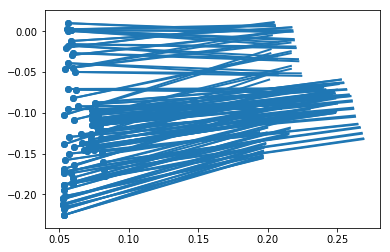

In [173]:
import matplotlib.pyplot as plt
import pylab as pl
from matplotlib import collections  as mc
%matplotlib inline
lines = []
scat_x = []
scat_y = []
for i in range(len(x_fit)):
    lines.append([x_fit[i], xdot_fit[i]])
    scat_x.append(xdot_fit[i][0])
    scat_y.append(xdot_fit[i][1])
lc = mc.LineCollection(lines, linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.autoscale()
plt.scatter(scat_x, scat_y)

In [126]:
lines

[[array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.00022015, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  a

In [87]:
lines

[[array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  array([ 0.10353177, -0.09634653], dtype=float32)],
 [array([ 0.10331162, -0.06452201], dtype=float32),
  a

In [174]:
marker[300:500]

[defaultdict(dict,
             {'Gate10': {1: {'pos': array([541.60016, 323.34143], dtype=float32),
                'ray': array([0.0093177 , 0.99821052, 0.05906763]),
                'dist': 0.28987597839186674},
               2: {'pos': array([488.26532, 323.42566], dtype=float32),
                'ray': array([-0.07068442,  0.99576016,  0.05886823]),
                'dist': 0.20500991939208466},
               3: {'pos': array([541.4313 , 378.10837], dtype=float32),
                'ray': array([ 0.00940951,  0.99864942, -0.05109712]),
                'dist': 0.3548765596272343},
               4: {'pos': array([488.3592, 378.0184], dtype=float32),
                'ray': array([-0.07079019,  0.99618864, -0.05095931]),
                'dist': 0.28767696435354667}}}),
 defaultdict(dict,
             {'Gate10': {1: {'pos': array([541.60016, 323.34143], dtype=float32),
                'ray': array([0.00934136, 0.99834458, 0.05675293]),
                'dist': 0.31290856773360876},
   